#  Break Haario Bardenet ACMC on a 2 dimensional Gaussian distribution by accepting proposal with some probability regardless of score

In this notebook, we deliberately break The Haario Bardenet ACMC sampler by causing it to incorrectly accept proposals with a certain probability. The sampler is used on the 1D Gaussian distribution.

## Define broken sampler

In [20]:
import pints
import random

class BrokenHaarioBardenetACMC(pints.HaarioBardenetACMC):
    """Broken version of Haario Bardenet ACMC.

    At each step, with probability given by error_freq, it will always
    accept the proposal. This proposal is NOT used for the covariance
    matrix adaption.
    """
    def __init__(self, x0, sigma0=None):
        super().__init__(x0, sigma0)
        self.error_freq = 0.0

    def set_error_freq(self, error_freq):
        self.error_freq = error_freq

    def tell(self, fx):
        if self.error_freq == 0.0 or random.random() > self.error_freq:
            # Run MH step correctly
            return super().tell(fx)
        else:
            # Always accept it even if it is bad
            # Increase iteration count
            self._iterations += 1

            # Accept
            self._acceptance_count += 1
            self._current = self._proposed
            self._current_log_pdf = float(fx)

            # Calculate acceptance rate
            self._acceptance_rate = self._acceptance_count / self._iterations

            # Clear proposal
            self._proposed = None

            return self._current

## Changepoint detection with hyperparameters I (marginal Rhat criterion)

We desire marginal $\hat{R}$s of <1.01 and ESS per chain to be greater >200 for each chain. The corresponing hyperparameters were found in the baseline notebook to be

1. Number of chains: 3
2. Number of iterations: 4000 (first 1000 iterations are warmup)
3. Other hyperparameters: Default

### Compute Kullback-Leibler divergence for 15 unbroken and 15 broken posteriors

In [21]:
import numpy as np
import pints.toy
from tqdm.notebook import tqdm

def estimate_klds(
        sampler, kld_func, n_runs, n_chains, n_iterations, warmup, 
        break_run, error_freq):
    """Run MCMC multiple times, break at some point, and get the KL divs.
    
    It uses the BrokenMH sampler and the 1D Gaussian distribution.

    Parameters
    ----------
    sampler : pints.MCMCSampler
        Method that is used for sampling
    kld_func : function
        Function that returns Kullback-Leibler metric for given chain samples
    n_runs : int
        Total number of runs
    n_chains : int
        Number of chains per run
    n_iterations : int
        Number of iterations run per chain
    warmup : int
        Number of warmup iterations
    break_run : int
        Which run to break the MCMC algorithm
    error_freq : float
        Error probability per MH step once the algorithm is broken

    Returns
    -------
    list
        List of kl divergences from samples to posterior for each run
    """
    # Define pdf 
    # (prior is only used to sample starting positions for chains)
    normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
    log_prior = pints.ComposedLogPrior(
        pints.GaussianLogPrior(mean=0, sd=3),
        pints.GaussianLogPrior(mean=0, sd=3))

    # Set up hyperparameters
    initial_parameters = log_prior.sample(n=n_chains)
    is_run_parallel = True

    # Estimate kld for each run
    klds = []
    for run in tqdm(range(n_runs)):
        # Set up sampler
        mcmc = pints.MCMCController(
            normal_log_pdf, n_chains, initial_parameters, method=sampler)
        mcmc.set_max_iterations(n_iterations)
        mcmc.set_log_to_screen(False)
        mcmc.set_parallel(is_run_parallel)

        # Break sampler if break run is reached
        if run >= break_run:
            for s in mcmc.samplers():
                s.set_error_freq(error_freq)

        # Infer posterior and reshape samples as if they were one chain
        chains = mcmc.run()
        chains_x = chains[:, warmup:, 0].flatten()
        chains_y = chains[:, warmup:, 1].flatten()
        chains = np.vstack([chains_x, chains_y]).T

        kld = kld_func(chains)
        klds.append(kld)

    return klds

In [25]:
from functools import partial

from bayesian_changepoint_detection import online_changepoint_detection as oncd

def run_changepoint(data):
    """Run changepoint detection using the library.
    """
    ## Set hyperparameters
    # timescale of hazard function
    lam = 250

    # T distribution parameters
    # df=2*self.alpha,
    # loc=self.mu,
    # scale=np.sqrt(self.beta * (self.kappa+1) / (self.alpha * self.kappa))
    alpha = 0.1
    beta = 0.01
    kappa = 1.0
    mu = 0.0

    R, maxes = oncd.online_changepoint_detection(
        data,
        partial(oncd.constant_hazard, lam),
        oncd.StudentT(alpha, beta, kappa, mu))

    return R

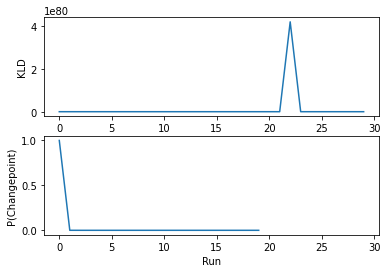

In [26]:
import matplotlib.pyplot as plt

# Define kld func
normal_log_pdf = pints.toy.GaussianLogPDF(mean=[0, 0], sigma=[1, 1])
kld_func = normal_log_pdf.kl_divergence

# Estimate KLDs
klds = estimate_klds(
    sampler=BrokenHaarioBardenetACMC, 
    kld_func=kld_func,
    n_runs=30, 
    n_chains=3, 
    n_iterations=4000, 
    warmup=1000, 
    break_run=15, 
    error_freq=0.15)
R = run_changepoint(klds)

In [27]:
klds

[0.00278539008995482,
 0.0012616450999647366,
 0.0018071747801942095,
 0.005760110461076273,
 0.0021508896655073606,
 0.0013256490766089257,
 0.0035086608567245214,
 0.001239899650102183,
 0.0016453611223967712,
 0.0021347429980012045,
 0.0023070442092301136,
 0.005953017402954952,
 0.004904914521389525,
 0.0016568647661534541,
 0.0010818138350159323,
 1.7865898204585411e+53,
 5.820327490794111e+42,
 3.3342554066808975e+21,
 1.1798808382836007e+35,
 2.1424507098599952e+49,
 2.3576602012788798e+44,
 1.2158301055135044e+46,
 4.177594091703061e+80,
 2.373724849364185e+36,
 1.2433991959420374e+30,
 3.826890276580098e+37,
 1.3210978750828284e+32,
 2.8503150897287426e+41,
 1.8444684704749885e+32,
 9.575048472804444e+50]

In [29]:
R

array([[1.00000000e+000, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003, 4.00000000e-003, 4.00000000e-003,
        4.00000000e-003],
       [0.00000000e+000, 9.96000000e-001, 8.48150346e-004,
        5.44232966e-004, 4.23123575e-004, 3.55185779e-004,
        3.11300507e-004, 2.80029270e-004, 2.56425303e-004,
        2.37757385e-004, 2.22583916e-004, 2.09956188e-004,
        1.99946471e-004, 1.90336057e-004, 1.82038983e-004,
        1.74977865e-004, 9.96000000e-001, 6.76096441e-002,
        9.96000000e-001, 9.959

### Visualise results

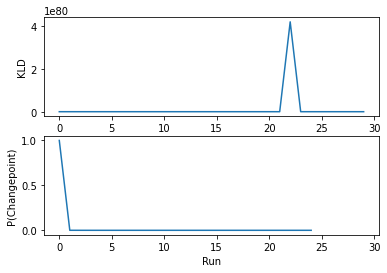

In [28]:
# Plot results
fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)

# Plot KLDs
runs = np.arange(len(klds))
ax.plot(runs, klds)
ax.set_ylabel('KLD')

# Plot changepoint probablities
ax = fig.add_subplot(2, 1, 2, sharex=ax)
window_size = 5  # How many time points to get before evaluating probability
ax.plot(runs[:-window_size], R[window_size, window_size:-1])

ax.set_xlabel('Run')
ax.set_ylabel('P(Changepoint)')
plt.show()

## TODO: Hyperparameters I: Multivariate $\hat{R} < 1.01$ and an effective sample size per parameter $>200$ per chain.

In [5]:

def _within(chains):
    # Get number of chains and number of parameters
    n_chains, _, n_parameters = chains.shape

    # Compute unbiased within-chain covariance estimate
    within_chain_cov = np.empty(shape=(n_chains, n_parameters, n_parameters))
    for chain_id, chain in enumerate(chains):
        within_chain_cov[chain_id] = np.cov(chain, ddof=1, rowvar=False)

    # Compute mean-within chain variance
    w = np.mean(within_chain_cov, axis=0)

    return w

def _between(chains):
    # Get number of samples
    n = chains.shape[1]

    # Compute within-chain mean
    within_chain_means = np.mean(chains, axis=1)

    # Compute covariance across chains of within-chain means
    between_chain_cov = np.cov(within_chain_means, ddof=1, rowvar=False)

    # Weight variance with number of samples per chain
    b = n * between_chain_cov

    return b

def multidimensional_rhat(chains):
    # Get number of samples
    n = chains.shape[1]

    # Split chains in half
    n = n // 2  # new length of chains
    if n < 1:
        raise ValueError(
            'Number of samples per chain after warm-up and chain splitting is '
            '%d. Method needs at least 1 sample per chain.' % n)
    chains = np.vstack([chains[:, :n], chains[:, -n:]])

    # Compute mean within-chain covariance
    w = _within(chains)

    # Compute mean between-chain convariance
    b = _between(chains)

    # Compute Rhat
    rhat = np.sqrt((n - 1.0) / n + np.linalg.det(b) / (np.linalg.det(w) * n))

    return rhat

### Visualise $\hat{R}$ and ESS over number of iterations

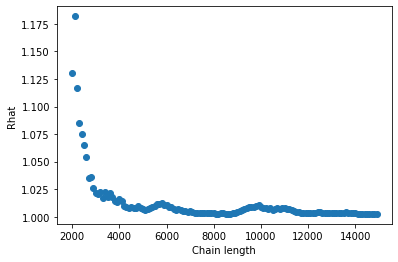

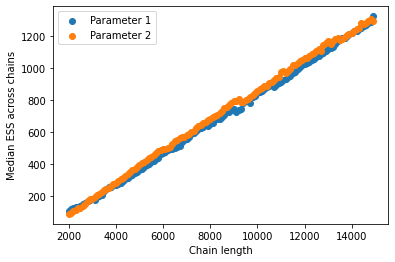

In [6]:
import numpy as np

# Define chain lengths for Rhat evaluation
warmup = 1000
chain_lengths = np.arange(start=2000, stop=15000, step=100)

# Compute rhat
n_parameters = 2
n_lengths = len(chain_lengths)
rhats = np.empty(shape=n_lengths)
ess = np.empty(shape=(n_chains, n_lengths, n_parameters))
for length_id, chain_length in enumerate(chain_lengths):
    # Get relevant chain samples
    cleaned_chains = chains[:, warmup:chain_length]

    # Compute rhat and ess
    rhats[length_id] = multidimensional_rhat(cleaned_chains)
    for chain_id, chain in enumerate(cleaned_chains):
        ess[chain_id, length_id] = pints.effective_sample_size(chain)

# Plot evolution of rhat
plt.scatter(x=chain_lengths, y=rhats)
plt.xlabel('Chain length')
plt.ylabel('Rhat')
plt.show()

# Plot evolution of ess
median_ess = np.median(ess, axis=0)
plt.scatter(x=chain_lengths, y=median_ess[:, 0], label='Parameter 1')
plt.scatter(x=chain_lengths, y=median_ess[:, 1], label='Parameter 2')
plt.xlabel('Chain length')
plt.ylabel('Median ESS across chains')
plt.legend()
plt.show()

### Conclusion on hyperparameters

We desire a multivariate $\hat{R}$s of <1.01 and ESS per chain to be greater >200 for each chain. This suggests the following hyperparameters to satisfy these conditions

1. Number of chains: 10
2. Number of iterations: 10000 (first 1000 iterations are warmup)
3. Other hyperparameters: Default